# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> DL MATH + DATATHON = DL MATHON


*   Written by Seungeun Lee
*   대회에서 사용되는 모든 이미지는 모델 학습을 위해서만 사용해주세요 (다른 용도로 사용 금지!)
*   Please use all images from the competition only for model training (no other uses!)

### Track 1. 한국 음식 이미지 분류
##### https://www.kaggle.com/competitions/2021-data-creator-camp-1120-1/data
##### 2021 데이터 크리에이터 캠프 (NIA 주최 데이터 분석 대회)에 출제된 문제입니다.
##### 학습데이터 : 3496 장 / 검증데이터 : 689 장 / 평가데이터 : 958 장으로 구성되어 있지만, 평가데이터에 대한 정답지가 없기 때문에 학습데이터 학습하고, 검증데이터로 평가하도록 하겠습니다 (평가데이터는 무시해주세요)
##### target은 BoiledDown (조림) / Rice (밥) / Noodle (면) / Roasted (구이) / Kimchi (김치) 총 5개로 구성되어 있습니다.
##### hhttps://drive.google.com/file/d/1wBJRhn7R_puujj_2LXjq-xvG03LucaFO/view?usp=drive_link




### Track 1. Korean Food Image Classification
##### https://www.kaggle.com/competitions/2021-data-creator-camp-1120-1/data
#####  This problem was presented at the 2021 Data Creator Camp, organized by NIA (National Information Society Agency).
##### The dataset consists of 3496 training images, 689 validation images, and 958 evaluation images. However, there are no ground truth labels for the evaluation data. Therefore, training will be performed on the training data, and evaluation will be carried out on the validation data (please disregard the evaluation data).
##### The target categories include BoiledDown, Rice, Noodle, Roasted, and Kimchi, totaling 5 classes.
##### https://drive.google.com/file/d/1wBJRhn7R_puujj_2LXjq-xvG03LucaFO/view?usp=drive_link

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet means and std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),             # Resize the shorter side to 256
        transforms.CenterCrop(224),         # Crop the center 224x224
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet means and std
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/intro-dl/kfood/", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}

In [6]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


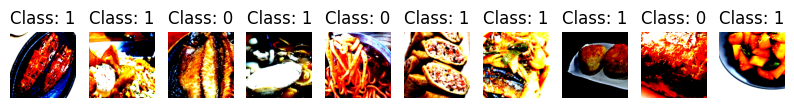

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
import torchvision.models as models
model = models.resnet50(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [9]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(DEVICE)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)

In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        output = model(image)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE, dtype=torch.long)
            output = model(image)
            test_loss += criterion(output, label).item()

            probs = torch.softmax(output, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    roc_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr', average='macro')
    return test_loss, roc_auc

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, auc_score = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tAUC Score: {:.2f} \n".format(
        epoch, valid_loss, auc_score))

Train Epoch: 1 [0/5132 (0%)]	Train Loss: 1.405603
Train Epoch: 1 [160/5132 (3%)]	Train Loss: 0.877449
Train Epoch: 1 [320/5132 (6%)]	Train Loss: 0.800989
Train Epoch: 1 [480/5132 (9%)]	Train Loss: 1.063558
Train Epoch: 1 [640/5132 (12%)]	Train Loss: 1.029763
Train Epoch: 1 [800/5132 (16%)]	Train Loss: 0.972385
Train Epoch: 1 [960/5132 (19%)]	Train Loss: 0.798466
Train Epoch: 1 [1120/5132 (22%)]	Train Loss: 0.752159
Train Epoch: 1 [1280/5132 (25%)]	Train Loss: 0.629864
Train Epoch: 1 [1440/5132 (28%)]	Train Loss: 0.966439
Train Epoch: 1 [1600/5132 (31%)]	Train Loss: 0.747843


KeyboardInterrupt: 

### Track 2. Turtle Classification
##### Suinne's pet turtle, 'Ddubuki' vs not_ddubuki
##### In data science, especially in academic projects, a significant amount of time is dedicated not only to implementing and developing models but also to the crucial task of data preprocessing. This is due to the varied formats of data (jpg, heic, png, tiff, etc.) and the potential differences in colormaps.
##### Additionally, real-world data is often limited in quantity, and there is a significant imbalance in the distribution of targets, making classification challenging.
##### Through Track 2, we aim to explore methods to address these practical challenges. Please start with preprocessing the data, unifying it into a single file format, considering the various extensions. It is recommended to use libraries such as 'os', that you have learned previously.
##### The dataset consists of 98 training images and 21 evaluation images.
##### The target classes are ddubuk and not_ddubuk.
##### https://drive.google.com/file/d/1pHQMKPBvY1kju82i64fCB-yVyEtnWybh/view?usp=drive_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow pyheif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 73.8 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import pyheif

In [ ]:
def change_to_jpg(directory):
  for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)

    if filename.lower().endswith('.heic'):
      heif_file = pyheif.read(file_path)
      img = Image.frombytes(
          heif_file.mode,
          heif_file.size,
          heif_file.data,
          "raw",
          heif_file.mode,
          heif_file.stride,
      )
    else:
      img = Image.open(file_path)
    # Open file

    img = img.convert('RGB')
    # Convert to RGB

    new_filename = os.path.splitext(filename)[0] + '.jpg'
    new_file_path = os.path.join(directory, new_filename)
    img.save(new_file_path, 'JPEG')
    # Save the image as .jpg

    os.remove(file_path)
    # Remove the original file

In [ ]:
path = '/content/drive/MyDrive/intro-dl/ddubuk'
change_to_jpg(path+'/train/ddubuk')
change_to_jpg(path+'/train/not_ddubuk')
change_to_jpg(path+'/test/ddubuk')
change_to_jpg(path+'/test/not_ddubuk')

In [ ]:
# ---------------- 데이터 전처리 ---------------- #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet means and std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),             # Resize the shorter side to 256
        transforms.CenterCrop(224),         # Crop the center 224x224
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet means and std
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/intro-dl/ddubuk", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}

In [ ]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


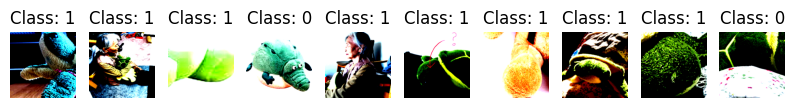

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
import torchvision.models as models
model = models.resnet50(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.9MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image)

        output = output.squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.float)
            output = model(image)

            output = output.squeeze(dim=1)
            test_loss += criterion(output, label).item()

            probs = torch.sigmoid(output).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(label.cpu().numpy())

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    roc_auc = roc_auc_score(all_labels, all_preds)
    return test_loss, roc_auc

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, auc_score = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tAUC Score: {:.2f} \n".format(
        epoch, valid_loss, auc_score))

Train Epoch: 1 [0/111 (0%)]	Train Loss: 0.689345

[EPOCH: 1], 	Test Loss: 0.6900, 	Test Accuracy: 81.98 % 

Train Epoch: 2 [0/111 (0%)]	Train Loss: 0.677781

[EPOCH: 2], 	Test Loss: 0.6119, 	Test Accuracy: 81.98 % 

Train Epoch: 3 [0/111 (0%)]	Train Loss: 0.469399

[EPOCH: 3], 	Test Loss: 0.5173, 	Test Accuracy: 81.98 % 

Train Epoch: 4 [0/111 (0%)]	Train Loss: 0.571480

[EPOCH: 4], 	Test Loss: 0.5263, 	Test Accuracy: 81.98 % 

Train Epoch: 5 [0/111 (0%)]	Train Loss: 0.181302

[EPOCH: 5], 	Test Loss: 0.4695, 	Test Accuracy: 81.98 % 

Train Epoch: 6 [0/111 (0%)]	Train Loss: 0.535334

[EPOCH: 6], 	Test Loss: 0.5387, 	Test Accuracy: 85.59 % 

Train Epoch: 7 [0/111 (0%)]	Train Loss: 0.484072

[EPOCH: 7], 	Test Loss: 0.5289, 	Test Accuracy: 81.98 % 

Train Epoch: 8 [0/111 (0%)]	Train Loss: 0.446967

[EPOCH: 8], 	Test Loss: 0.5100, 	Test Accuracy: 81.98 % 

Train Epoch: 9 [0/111 (0%)]	Train Loss: 0.489318

[EPOCH: 9], 	Test Loss: 0.4567, 	Test Accuracy: 86.49 % 

Train Epoch: 10 [0/111 (0%)]

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/DLMATHon

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

*   결과물을 업로드한 후에 저 (승은)에게 개인톡으로 알려주시면 leaderboard에 결과를 반영하겠습니다
*   평가데이터를 학습데이터에 사용하는 행위 등 cheating과 FastAI와 같은 shortcut 사용은 안 돼요~!!

*   After uploading your results, please inform me (Seungeun) through personal chat, and I will reflect the results on the leaderboard
*   Cheating, such as using evaluation data for training, and shortcuts like FastAI, are not allowed. Thank you for your understanding!